In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [45]:
# Image size and batch size
image_size = (224, 224)
batch_size = 32
train_dir = 'data/train'
test_dir = 'data/test'

In [55]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for proper evaluation
)


Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [56]:
# Load the ResNet50 model with pre-trained ImageNet weights
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(*image_size, 3),
    weights='resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
)

# Freeze the base model initially
base_model.trainable = False

# Create the model with regularization
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')
])

In [49]:
# Initial training with frozen base
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# First training phase
print("Initial training with frozen base model...")
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

# Fine-tuning phase
print("\nFine-tuning the model...")
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3745 - loss: 1.1946 - val_accuracy: 0.3421 - val_loss: 1.0857
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3507 - loss: 1.0783 - val_accuracy: 0.3772 - val_loss: 1.0780
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3802 - loss: 1.1051 - val_accuracy: 0.3772 - val_loss: 1.0805
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3547 - loss: 1.0885 - val_accuracy: 0.4561 - val_loss: 1.0296
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3947 - loss: 1.0763 - val_accuracy: 0.3947 - val_loss: 1.0638
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4154 - loss: 1.0530 - val_accuracy: 0.4474 - val_loss: 1.0258
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4481 - loss: 1.0811 - val_accuracy: 0.5175 - val_loss: 1.0113
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4750 - loss: 1.0419 - val_accuracy: 0.5000 - val_loss:

In [50]:
# Evaluation
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


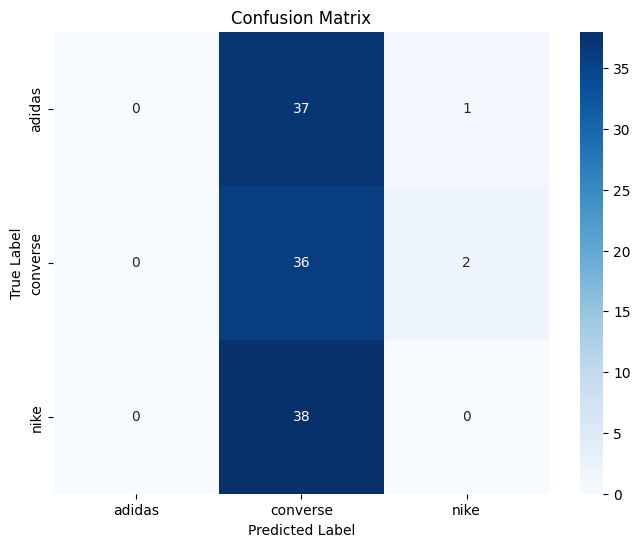

In [51]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_data.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [52]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.00      0.00      0.00        38
    converse       0.32      0.95      0.48        38
        nike       0.00      0.00      0.00        38

    accuracy                           0.32       114
   macro avg       0.11      0.32      0.16       114
weighted avg       0.11      0.32      0.16       114



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  